In [1]:
using Plots
using LinearAlgebra
using Revise
using Optim
#using FFTW
using Zygote
using Nevanlinna
using LaTeXStrings
using MultiFloats
using SparseIR
#using DoubleFloats

In [2]:
# Set work data Type
#T = Float64x2
T = BigFloat

BigFloat

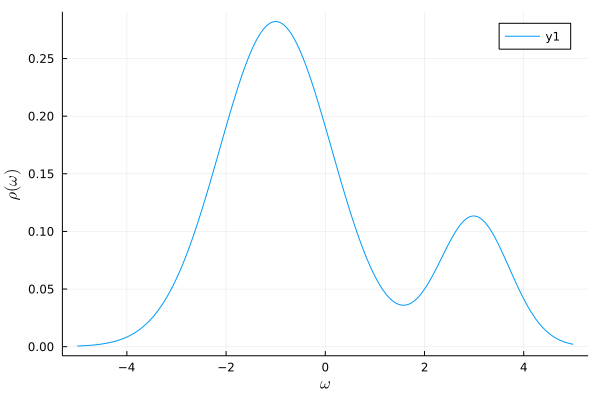

In [3]:
gaussian(x, mu, sigma) = exp(-((x-mu)/sigma)^2)/(sqrt(π)*sigma)
lorentzian(x, mu, gamma) = gamma/(pi*(gamma^2+(x-mu)^2))

#on-centered gaussian 23s
#rho(omega) = gaussian(omega, 0.0, 0.15)  

#on-centered lorentzian 2340s
#rho(omega) = lorentzian(omega, 0.0, 0.15)  

#two peak model 4403s
rho(omega) = 0.8*gaussian(omega, -1.0, 1.6) + 0.2*gaussian(omega, 3, 1)

#rho(omega) = 0.8*lorentzian(omega, -1.0, 1.6) + 0.2*lorentzian(omega, 3, 1)

#three peak model 1255s
#rho(omega) = 0.4*gaussian(omega, 1.0, 0.5) + 
#    0.4*gaussian(omega, 3.0, 0.8) + 0.2*gaussian(omega, -2.0, 1.0) 

# Hubbard gap 2619s
#rho(omega) = 0.5*gaussian(omega, -3.0, 1.0) + 0.5*gaussian(omega, 3.0, 1.0) 

omegas = LinRange(-5, 5, 1000)
#plt.xlabel(L"\omega")
#plt.ylabel(L"\rho(\omega)")
#plt.plot(omegas, rho.(omegas))
plot(omegas, rho.(omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

In [4]:
setprecision(512)
;

In [72]:
beta = 100
wmax = 100
IR_basis_set = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) #もともと-7
#basis = FiniteTempBasis(fermion, beta, wmax, 1e-7)

rhol = [overlap(IR_basis_set.basis_f.v[l], rho) for l in 1:length(IR_basis_set.basis_f)]
gl = - IR_basis_set.basis_f.s .* rhol
;

In [73]:
#off-centered delta function
#rhol = (IR_basis_set.basis_f.v(0.2))
#gl = - IR_basis_set.basis_f.s .* rhol
;

In [74]:
gw = evaluate(IR_basis_set.smpl_wn_f, gl)
hnw = length(IR_basis_set.smpl_wn_f.sampling_points)÷2

52

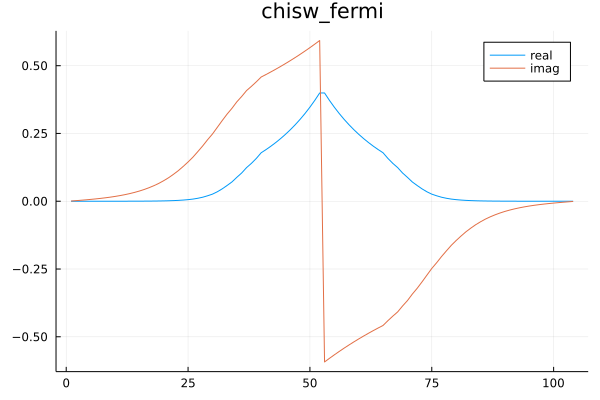

In [75]:
plot(title="chisw_fermi")
plot!(real.(gw[:]), label="real")
plot!(imag.(gw[:]), label="imag")

In [76]:
sum = -dot(IR_basis_set.basis_f.u(beta), gl) - dot(IR_basis_set.basis_f.u(0), gl)

0.9999999999999997

In [77]:
test_gw   = Array{Complex{T}}(undef, hnw) 
test_smpl = Array{Complex{T}}(undef, hnw) 
;

In [78]:
for i in 1:hnw
    test_smpl[i]= SparseIR.valueim(IR_basis_set.smpl_wn_f.sampling_points[hnw+i], SparseIR.β(IR_basis_set))
    test_gw[i]  = gw[hnw+i]
end

In [79]:
N_real    =  1000
omega_max =  10.0
eta       =  0.001
H_max     =  50
ab_coeff  = zeros(ComplexF64, 2*H_max) 
lambda    = 1e-5
iter_tol  = 1000
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw, test_smpl, test_gw)
#N_imag = 38
println("N_imp $(N_imag)")
;

N_imag is setted as 31
N_imp 31


In [86]:
@time sol = Nevanlinna.NevanlinnaSolver(N_imag, test_smpl, test_gw, N_real, omega_max, eta, sum, H_max, iter_tol, lambda, true, mesh=:log)
#@time sol = Nevanlinna.NevanlinnaSolver(N_imag, test_smpl, test_gw, N_real, omega_max, eta, sum, H_max, iter_tol, lambda, true)
;

Pick matrix is positive semi-definite.
H=1
Iter     Function value   Gradient norm 
     0     1.600029e-02     1.674829e-01
 * time: 0.00019288063049316406
     1     1.526355e-02     8.767496e-02
 * time: 0.23789000511169434
     2     4.036891e-03     2.555590e-02
 * time: 0.5606169700622559
     3     4.011663e-03     7.396456e-04
 * time: 0.9339418411254883
     4     4.011623e-03     2.713824e-06
 * time: 1.3114049434661865
     5     4.011623e-03     1.469791e-07
 * time: 1.5788190364837646
     6     4.011623e-03     2.894651e-09
 * time: 1.9040379524230957
max_theta=0.0769349198298035379826943610470134923815373332218270134505762190375634825023287224614798153789846085191197901349187992372142930953903414571271505348284777274
hardy optimization was success.
  2.559477 seconds (32.05 M allocations: 2.142 GiB, 24.35% gc time)


In [87]:
@time Nevanlinna.solve!(sol)

H=1
Iter     Function value   Gradient norm 
     0     4.011623e-03     2.894651e-09
 * time: 0.00019097328186035156
max_theta=0.0769349198298035379826943610470134923815373332218270134505762190375634825023287224614798153789846085191197901349187992372142930953903414571271505348284777274
hardy optimization was success.
H=2
Iter     Function value   Gradient norm 
     0     4.011623e-03     5.295002e-02
 * time: 0.0002129077911376953
     1     3.920899e-03     5.892011e-02
 * time: 0.25463390350341797
     2     2.760711e-03     3.893470e-02
 * time: 0.5161168575286865
     3     1.201799e-03     3.612261e-03
 * time: 0.7725200653076172
     4     1.155066e-03     9.747511e-03
 * time: 1.3375439643859863
     5     9.571831e-04     4.957639e-04
 * time: 1.84511399269104
     6     9.567009e-04     3.661861e-05
 * time: 2.258636951446533
     7     9.566993e-04     8.443663e-07
 * time: 2.6733100414276123
     8     9.566993e-04     1.352431e-07
 * time: 3.031913995742798
     9     9.5

    14     7.513331e-06     3.052292e-05
 * time: 8.617676973342896
    15     7.510000e-06     2.137982e-05
 * time: 9.208894968032837
    16     7.178116e-06     3.517490e-05
 * time: 10.450547933578491
    17     7.161009e-06     4.879951e-06
 * time: 11.03484296798706
    18     7.159227e-06     1.909998e-05
 * time: 12.039183139801025
    19     6.411175e-06     1.742987e-04
 * time: 13.283556938171387
    20     6.282344e-06     3.074751e-06
 * time: 13.870670080184937
    21     6.282303e-06     7.143495e-08
 * time: 14.237697124481201
    22     6.282303e-06     4.703337e-10
 * time: 14.656670093536377
max_theta=0.275676077038755863918216169749033719770305049145636550305658325951140898030861953294783684977949452317356330152391730828604635399170169777657466165826669097
hardy optimization was success.
H=8
Iter     Function value   Gradient norm 
     0     6.282303e-06     5.507354e-04
 * time: 0.00022292137145996094
     1     6.275787e-06     6.041256e-04
 * time: 0.46515393257

     7     1.563567e-06     2.816112e-05
 * time: 3.1699600219726562
     8     1.561344e-06     2.726289e-05
 * time: 3.637805938720703
     9     1.559557e-06     1.857729e-05
 * time: 4.084929943084717
    10     1.557411e-06     1.803882e-05
 * time: 4.760870933532715
    11     1.552801e-06     1.460130e-05
 * time: 5.435476064682007
    12     1.550531e-06     1.638303e-05
 * time: 6.129251003265381
    13     1.543029e-06     1.021880e-05
 * time: 7.0137879848480225
    14     1.540391e-06     2.706736e-05
 * time: 7.93046498298645
    15     1.539432e-06     6.650853e-05
 * time: 8.606935024261475
    16     1.532050e-06     5.910514e-06
 * time: 9.495881080627441
    17     1.519693e-06     1.762526e-05
 * time: 10.635040044784546
    18     1.519046e-06     2.814543e-06
 * time: 11.28502893447876
    19     1.513433e-06     8.692064e-06
 * time: 12.639457941055298
    20     1.513232e-06     1.557666e-06
 * time: 13.325298070907593
    21     1.507156e-06     1.554837e-05
 * 

     0     1.323518e-06     1.951544e-05
 * time: 0.0002300739288330078
     1     1.323513e-06     1.968024e-05
 * time: 0.5323550701141357
     2     1.323506e-06     1.664553e-05
 * time: 1.0948739051818848
     3     1.323496e-06     9.641031e-06
 * time: 1.6314709186553955
     4     1.323482e-06     8.761449e-06
 * time: 2.1566219329833984
     5     1.323465e-06     7.317809e-06
 * time: 2.7232539653778076
     6     1.323439e-06     6.947145e-06
 * time: 3.256350040435791
     7     1.323413e-06     5.346427e-06
 * time: 3.809551954269409
     8     1.323375e-06     5.504336e-06
 * time: 4.340835094451904
     9     1.323333e-06     4.225203e-06
 * time: 4.873773097991943
    10     1.323276e-06     4.291982e-06
 * time: 5.452390909194946
    11     1.323210e-06     3.663319e-06
 * time: 5.998676061630249
    12     1.323123e-06     3.862624e-06
 * time: 6.814882040023804
    13     1.323033e-06     2.630667e-06
 * time: 7.632599115371704
    14     1.322934e-06     2.023996e-0

    29     1.311696e-06     1.477384e-07
 * time: 28.293957948684692
    30     1.311693e-06     6.946315e-07
 * time: 29.880650997161865
    31     1.311650e-06     9.442614e-08
 * time: 31.089020013809204
    32     1.311648e-06     2.627297e-07
 * time: 32.65728688240051
    33     1.311593e-06     9.554164e-08
 * time: 34.183521032333374
    34     1.311593e-06     1.177531e-07
 * time: 35.107584953308105
    35     1.311486e-06     1.231349e-07
 * time: 36.95503091812134
    36     1.311485e-06     7.889255e-08
 * time: 37.87781095504761
    37     1.311473e-06     5.252651e-07
 * time: 40.05448389053345
    38     1.311380e-06     4.719123e-08
 * time: 41.25635504722595
    39     1.311380e-06     4.212926e-08
 * time: 42.1755850315094
    40     1.311362e-06     2.999649e-07
 * time: 44.35178995132446
    41     1.310959e-06     6.635459e-08
 * time: 45.585205078125
    42     1.310959e-06     5.959399e-09
 * time: 46.51334500312805
max_theta=0.4317620495794780474571306429713944

    50     1.308677e-06     1.632646e-07
 * time: 54.94019603729248
    51     1.308667e-06     5.453200e-08
 * time: 55.95619821548462
    52     1.308667e-06     5.676847e-08
 * time: 56.97054719924927
    53     1.308667e-06     5.631286e-08
 * time: 57.975993156433105
    54     1.308666e-06     7.959241e-08
 * time: 59.31211304664612
    55     1.308657e-06     2.055068e-07
 * time: 60.65142512321472
    56     1.308628e-06     1.576743e-07
 * time: 61.64848303794861
    57     1.308619e-06     3.571301e-08
 * time: 62.64447903633118
    58     1.308619e-06     3.722462e-08
 * time: 63.634512186050415
    59     1.308619e-06     3.746209e-08
 * time: 64.64344620704651
    60     1.308619e-06     3.556528e-08
 * time: 65.98135805130005
    61     1.308616e-06     9.007710e-08
 * time: 67.32839512825012
    62     1.308588e-06     2.500435e-07
 * time: 68.63425803184509
    63     1.308515e-06     2.380860e-07
 * time: 69.62040305137634
    64     1.308499e-06     3.093618e-08
 * ti

     8     1.306954e-06     6.782585e-06
 * time: 7.240756988525391
     9     1.306918e-06     6.481474e-06
 * time: 8.191596031188965
    10     1.306855e-06     7.531374e-06
 * time: 9.06504201889038
    11     1.306797e-06     7.329299e-06
 * time: 9.985393047332764
    12     1.306711e-06     6.010108e-06
 * time: 10.802255868911743
    13     1.306613e-06     5.075843e-06
 * time: 11.763658046722412
    14     1.306508e-06     5.687727e-06
 * time: 12.706504821777344
    15     1.306352e-06     3.720559e-06
 * time: 13.534798860549927
    16     1.306214e-06     4.960457e-06
 * time: 14.918237924575806
    17     1.306069e-06     2.967108e-06
 * time: 16.299598932266235
    18     1.305942e-06     2.229876e-06
 * time: 17.672407865524292
    19     1.305829e-06     2.322647e-06
 * time: 19.043635845184326
    20     1.305681e-06     1.480350e-06
 * time: 20.876598834991455
    21     1.305630e-06     1.744580e-06
 * time: 22.2678279876709
    22     1.305594e-06     1.587001e-06


   128     1.304581e-06     1.947174e-07
 * time: 144.68562483787537
   129     1.304574e-06     3.359382e-07
 * time: 145.7705478668213
   130     1.304569e-06     2.395152e-07
 * time: 146.48943495750427
   131     1.304561e-06     3.752847e-07
 * time: 147.59927082061768
   132     1.304556e-06     2.842818e-07
 * time: 148.3145990371704
   133     1.304548e-06     4.015266e-07
 * time: 149.39946103096008
   134     1.304543e-06     3.143713e-07
 * time: 150.1038420200348
   135     1.304534e-06     4.058802e-07
 * time: 151.19904398918152
   136     1.304530e-06     3.288720e-07
 * time: 151.95913887023926
   137     1.304521e-06     3.976648e-07
 * time: 153.03792691230774
   138     1.304517e-06     3.303250e-07
 * time: 153.75787496566772
   139     1.304505e-06     3.076950e-07
 * time: 154.8392689228058
   140     1.304484e-06     2.879401e-07
 * time: 156.26921391487122
   141     1.304469e-06     2.654151e-07
 * time: 157.04908204078674
   142     1.304457e-06     2.201672e-

   248     1.303689e-06     3.564040e-07
 * time: 252.33663702011108
   249     1.303676e-06     1.684001e-07
 * time: 253.04937195777893
   250     1.303669e-06     2.216440e-07
 * time: 253.8221719264984
   251     1.303665e-06     1.430019e-07
 * time: 254.55938601493835
   252     1.303662e-06     1.757368e-07
 * time: 255.2818078994751
   253     1.303659e-06     1.047489e-07
 * time: 256.0301809310913
   254     1.303657e-06     7.705556e-08
 * time: 256.7618749141693
   255     1.303656e-06     8.583464e-08
 * time: 257.48170804977417
   256     1.303656e-06     9.003589e-08
 * time: 258.1960849761963
   257     1.303655e-06     9.212225e-08
 * time: 258.9660918712616
   258     1.303655e-06     8.422819e-08
 * time: 259.69905400276184
   259     1.303654e-06     7.825043e-08
 * time: 260.4228160381317
   260     1.303654e-06     7.259200e-08
 * time: 261.2017140388489
   261     1.303654e-06     6.953902e-08
 * time: 261.9342260360718
   262     1.303654e-06     6.832905e-08
 *

   368     1.302968e-06     1.072127e-07
 * time: 361.52934288978577
   369     1.302968e-06     7.995124e-08
 * time: 362.34461784362793
   370     1.302967e-06     1.182841e-07
 * time: 363.5794520378113
   371     1.302967e-06     8.933456e-08
 * time: 364.39378786087036
   372     1.302966e-06     1.246938e-07
 * time: 365.6243088245392
   373     1.302966e-06     9.271280e-08
 * time: 366.4932780265808
   374     1.302965e-06     1.288502e-07
 * time: 367.67919993400574
   375     1.302965e-06     9.699470e-08
 * time: 368.5577640533447
   376     1.302964e-06     1.371211e-07
 * time: 369.7905628681183
   377     1.302964e-06     1.044628e-07
 * time: 370.6286759376526
   378     1.302963e-06     1.467770e-07
 * time: 371.87893199920654
   379     1.302962e-06     1.200365e-07
 * time: 372.66369700431824
   380     1.302962e-06     1.654265e-07
 * time: 373.9071578979492
   381     1.302961e-06     1.311515e-07
 * time: 374.7228889465332
   382     1.302960e-06     1.673930e-07
 

   488     1.301769e-06     2.230515e-08
 * time: 480.54988384246826
   489     1.301769e-06     2.091919e-08
 * time: 481.30556082725525
   490     1.301769e-06     2.380437e-08
 * time: 482.3934509754181
   491     1.301769e-06     2.217508e-08
 * time: 483.1008758544922
   492     1.301769e-06     2.510794e-08
 * time: 484.17049193382263
   493     1.301769e-06     2.336436e-08
 * time: 484.8784189224243
   494     1.301769e-06     2.637563e-08
 * time: 485.9580819606781
   495     1.301769e-06     2.467305e-08
 * time: 486.6557078361511
   496     1.301768e-06     2.780774e-08
 * time: 487.7466549873352
   497     1.301768e-06     2.627534e-08
 * time: 488.4549238681793
   498     1.301768e-06     2.954306e-08
 * time: 489.53095388412476
   499     1.301768e-06     2.822510e-08
 * time: 490.2811789512634
   500     1.301768e-06     3.151512e-08
 * time: 491.3442339897156
   501     1.301768e-06     3.031465e-08
 * time: 492.05233097076416
   502     1.301768e-06     3.352841e-08
 *

   609     1.301751e-06     2.496729e-07
 * time: 590.5387768745422
   610     1.301750e-06     2.585626e-07
 * time: 591.5722658634186
   611     1.301750e-06     2.575894e-07
 * time: 592.323422908783
   612     1.301749e-06     2.666286e-07
 * time: 593.4021680355072
   613     1.301749e-06     2.657357e-07
 * time: 594.1158900260925
   614     1.301748e-06     2.749167e-07
 * time: 595.2034649848938
   615     1.301747e-06     2.741054e-07
 * time: 595.9149198532104
   616     1.301747e-06     2.834259e-07
 * time: 597.0309948921204
   617     1.301746e-06     2.826984e-07
 * time: 597.7360968589783
   618     1.301745e-06     2.921607e-07
 * time: 598.8357219696045
   619     1.301745e-06     2.915226e-07
 * time: 599.597697019577
   620     1.301744e-06     3.011306e-07
 * time: 600.6434140205383
   621     1.301743e-06     3.005919e-07
 * time: 601.4037909507751
   622     1.301743e-06     3.103493e-07
 * time: 602.4960780143738
   623     1.301742e-06     3.099237e-07
 * time: 

   730     1.298684e-06     2.075818e-07
 * time: 697.8769218921661
   731     1.298673e-06     2.474986e-07
 * time: 698.5991280078888
   732     1.298663e-06     1.772475e-07
 * time: 699.3086528778076
   733     1.298655e-06     2.128159e-07
 * time: 700.0493879318237
   734     1.298648e-06     1.504940e-07
 * time: 700.7682368755341
   735     1.298641e-06     1.817045e-07
 * time: 701.4762768745422
   736     1.298636e-06     1.263536e-07
 * time: 702.1764419078827
   737     1.298632e-06     1.537019e-07
 * time: 702.9360859394073
   738     1.298628e-06     1.062878e-07
 * time: 703.6587719917297
   739     1.298625e-06     1.309174e-07
 * time: 704.370698928833
   740     1.298623e-06     9.023584e-08
 * time: 705.1275768280029
   741     1.298621e-06     1.118388e-07
 * time: 705.8450200557709
   742     1.298619e-06     7.654937e-08
 * time: 706.553957939148
   743     1.298617e-06     9.408279e-08
 * time: 707.2551259994507
   744     1.298616e-06     6.435148e-08
 * time: 

    78     1.298466e-06     2.329489e-07
 * time: 82.83730220794678
    79     1.298464e-06     2.965442e-07
 * time: 83.98595905303955
    80     1.298463e-06     8.649253e-08
 * time: 84.73961114883423
    81     1.298462e-06     1.547664e-07
 * time: 85.87730717658997
    82     1.298462e-06     5.079569e-08
 * time: 86.66042900085449
    83     1.298462e-06     1.081424e-07
 * time: 87.80664110183716
    84     1.298461e-06     5.655073e-08
 * time: 88.55081915855408
    85     1.298461e-06     1.171900e-07
 * time: 89.70309400558472
    86     1.298461e-06     6.788792e-08
 * time: 90.45075607299805
    87     1.298461e-06     1.263475e-07
 * time: 91.59088611602783
    88     1.298461e-06     7.770746e-08
 * time: 92.34403920173645
    89     1.298461e-06     1.811843e-07
 * time: 93.57506704330444
    90     1.298461e-06     1.466987e-07
 * time: 94.3223021030426
    91     1.298460e-06     2.138195e-07
 * time: 95.53958201408386
    92     1.298460e-06     1.865568e-07
 * time:

   198     1.298401e-06     2.349859e-08
 * time: 196.18231201171875
   199     1.298401e-06     4.349769e-08
 * time: 196.92306208610535
   200     1.298401e-06     2.138988e-08
 * time: 197.6533510684967
   201     1.298401e-06     3.878778e-08
 * time: 198.3789780139923
   202     1.298400e-06     1.976384e-08
 * time: 199.16747212409973
   203     1.298400e-06     3.716117e-08
 * time: 199.90638613700867
   204     1.298400e-06     1.870239e-08
 * time: 200.63909602165222
   205     1.298400e-06     3.794347e-08
 * time: 201.37599802017212
   206     1.298400e-06     1.806672e-08
 * time: 202.16220116615295
   207     1.298400e-06     3.989997e-08
 * time: 202.90392804145813
   208     1.298400e-06     2.273221e-08
 * time: 203.6380660533905
   209     1.298400e-06     4.267939e-08
 * time: 204.367112159729
   210     1.298400e-06     2.779173e-08
 * time: 205.15534210205078
   211     1.298400e-06     4.614126e-08
 * time: 205.89905714988708
   212     1.298400e-06     3.304958e-0

   318     1.298380e-06     1.249924e-07
 * time: 289.28089714050293
   319     1.298380e-06     1.027933e-07
 * time: 290.02053809165955
   320     1.298380e-06     9.748385e-08
 * time: 290.77153301239014
   321     1.298379e-06     8.122425e-08
 * time: 291.5379021167755
   322     1.298379e-06     7.563579e-08
 * time: 292.28192615509033
   323     1.298379e-06     6.621307e-08
 * time: 293.02037715911865
   324     1.298379e-06     5.574647e-08
 * time: 293.75426506996155
   325     1.298379e-06     5.412939e-08
 * time: 294.5204291343689
   326     1.298379e-06     4.102312e-08
 * time: 295.2626061439514
   327     1.298379e-06     4.471880e-08
 * time: 296.0020740032196
   328     1.298379e-06     3.119201e-08
 * time: 296.7327961921692
   329     1.298379e-06     3.668609e-08
 * time: 297.49673414230347
   330     1.298379e-06     2.360575e-08
 * time: 298.24113607406616
   331     1.298379e-06     2.964598e-08
 * time: 298.979266166687
   332     1.298379e-06     1.751837e-08


   438     1.298378e-06     1.137750e-07
 * time: 379.0890882015228
   439     1.298378e-06     1.177937e-07
 * time: 379.81567215919495
   440     1.298378e-06     1.169294e-07
 * time: 380.6040279865265
   441     1.298378e-06     1.209717e-07
 * time: 381.3454031944275
   442     1.298378e-06     1.201157e-07
 * time: 382.0767660140991
   443     1.298378e-06     1.241838e-07
 * time: 382.8046410083771
   444     1.298378e-06     1.233340e-07
 * time: 383.5966360569
   445     1.298378e-06     1.274301e-07
 * time: 384.3518400192261
   446     1.298378e-06     1.265840e-07
 * time: 385.0920031070709
   447     1.298378e-06     1.307104e-07
 * time: 385.82088112831116
   448     1.298378e-06     1.298657e-07
 * time: 386.64697217941284
   449     1.298378e-06     1.340246e-07
 * time: 387.39024019241333
   450     1.298378e-06     1.331789e-07
 * time: 388.12326216697693
   451     1.298378e-06     1.373725e-07
 * time: 388.8504340648651
   452     1.298378e-06     1.365233e-07
 * ti

    17     1.298243e-06     1.639199e-06
 * time: 13.803886890411377
    18     1.298228e-06     1.017914e-06
 * time: 15.004725933074951
    19     1.298207e-06     1.157850e-06
 * time: 16.19761610031128
    20     1.298191e-06     7.195864e-07
 * time: 17.380203008651733
    21     1.298187e-06     6.715459e-07
 * time: 18.16598892211914
    22     1.298173e-06     9.063556e-07
 * time: 19.347672939300537
    23     1.298163e-06     5.562054e-07
 * time: 20.53182888031006
    24     1.298155e-06     8.366048e-07
 * time: 21.316143035888672
    25     1.298148e-06     6.625688e-07
 * time: 22.500452995300293
    26     1.298142e-06     5.385313e-07
 * time: 23.64205288887024
    27     1.298135e-06     5.342247e-07
 * time: 24.854965925216675
    28     1.298130e-06     4.830375e-07
 * time: 25.621519088745117
    29     1.298125e-06     3.996056e-07
 * time: 26.449501037597656
    30     1.298121e-06     4.745209e-07
 * time: 27.231446027755737
    31     1.298116e-06     4.884856e-

   137     1.298017e-06     1.651751e-07
 * time: 123.63553595542908
   138     1.298016e-06     2.229829e-07
 * time: 124.44453310966492
   139     1.298016e-06     1.691631e-07
 * time: 125.23569393157959
   140     1.298015e-06     2.299634e-07
 * time: 126.02051210403442
   141     1.298015e-06     1.728420e-07
 * time: 126.81336998939514
   142     1.298014e-06     2.359514e-07
 * time: 127.66026496887207
   143     1.298014e-06     1.761519e-07
 * time: 128.46976900100708
   144     1.298013e-06     2.406140e-07
 * time: 129.26450991630554
   145     1.298013e-06     1.790444e-07
 * time: 130.05004501342773
   146     1.298012e-06     2.437975e-07
 * time: 130.89288306236267
   147     1.298012e-06     1.814857e-07
 * time: 131.6893389225006
   148     1.298011e-06     2.455350e-07
 * time: 132.4910650253296
   149     1.298010e-06     1.834580e-07
 * time: 133.30944204330444
   150     1.298010e-06     2.460101e-07
 * time: 134.09425687789917
   151     1.298009e-06     1.849598

   257     1.297953e-06     1.979035e-07
 * time: 220.5114450454712
   258     1.297952e-06     3.188796e-07
 * time: 221.31419610977173
   259     1.297951e-06     2.003297e-07
 * time: 222.10633492469788
   260     1.297950e-06     3.199421e-07
 * time: 222.8901379108429
   261     1.297949e-06     2.023373e-07
 * time: 223.73773193359375
   262     1.297948e-06     3.200922e-07
 * time: 224.53547310829163
   263     1.297947e-06     2.039077e-07
 * time: 225.33285188674927
   264     1.297946e-06     3.193413e-07
 * time: 226.12596893310547
   265     1.297945e-06     2.050369e-07
 * time: 226.90473103523254
   266     1.297945e-06     3.177258e-07
 * time: 227.74808502197266
   267     1.297944e-06     2.057355e-07
 * time: 228.55489206314087
   268     1.297943e-06     3.153064e-07
 * time: 229.39865589141846
   269     1.297942e-06     2.060280e-07
 * time: 230.19340991973877
   270     1.297941e-06     3.121659e-07
 * time: 230.97968196868896
   271     1.297940e-06     2.059510

   377     1.297879e-06     2.340601e-07
 * time: 317.3202829360962
   378     1.297879e-06     3.083328e-07
 * time: 318.12569403648376
   379     1.297878e-06     2.358748e-07
 * time: 318.9223279953003
   380     1.297878e-06     3.091904e-07
 * time: 319.7073600292206
   381     1.297877e-06     2.375964e-07
 * time: 320.54831290245056
   382     1.297876e-06     3.099379e-07
 * time: 321.3451108932495
   383     1.297876e-06     2.392114e-07
 * time: 322.1464900970459
   384     1.297875e-06     3.105383e-07
 * time: 322.93332290649414
   385     1.297875e-06     2.407055e-07
 * time: 323.73118591308594
   386     1.297874e-06     3.109587e-07
 * time: 324.53022599220276
   387     1.297874e-06     2.420643e-07
 * time: 325.389662027359
   388     1.297873e-06     3.111725e-07
 * time: 326.19826197624207
   389     1.297873e-06     2.432740e-07
 * time: 326.9887149333954
   390     1.297872e-06     3.111595e-07
 * time: 327.77119994163513
   391     1.297872e-06     2.443232e-07
 

   497     1.297826e-06     2.642926e-07
 * time: 414.0705680847168
   498     1.297825e-06     3.188251e-07
 * time: 414.86453795433044
   499     1.297825e-06     2.645315e-07
 * time: 415.64552187919617
   500     1.297824e-06     3.182550e-07
 * time: 416.42967200279236
   501     1.297824e-06     2.646246e-07
 * time: 417.24380707740784
   502     1.297824e-06     3.175857e-07
 * time: 418.0103569030762
   503     1.297823e-06     2.645674e-07
 * time: 418.78218388557434
   504     1.297823e-06     3.167936e-07
 * time: 419.541738986969
   505     1.297823e-06     2.643565e-07
 * time: 420.29386496543884
   506     1.297822e-06     3.158559e-07
 * time: 421.060427904129
   507     1.297822e-06     2.639902e-07
 * time: 421.8742311000824
   508     1.297822e-06     3.147520e-07
 * time: 422.6487579345703
   509     1.297821e-06     2.634684e-07
 * time: 423.40605998039246
   510     1.297821e-06     3.134651e-07
 * time: 424.1596179008484
   511     1.297821e-06     2.627930e-07
 *

   617     1.297793e-06     2.548501e-07
 * time: 506.8365800380707
   618     1.297793e-06     2.987230e-07
 * time: 507.6077170372009
   619     1.297793e-06     2.535520e-07
 * time: 508.36567902565
   620     1.297792e-06     2.976903e-07
 * time: 509.1237139701843
   621     1.297792e-06     2.521190e-07
 * time: 509.9333670139313
   622     1.297792e-06     2.965522e-07
 * time: 510.6996569633484
   623     1.297791e-06     2.505747e-07
 * time: 511.4742751121521
   624     1.297791e-06     2.953418e-07
 * time: 512.2446579933167
   625     1.297790e-06     2.489436e-07
 * time: 512.9970469474792
   626     1.297790e-06     2.940940e-07
 * time: 513.7865219116211
   627     1.297790e-06     2.472498e-07
 * time: 514.5583789348602
   628     1.297789e-06     2.928443e-07
 * time: 515.3377010822296
   629     1.297789e-06     2.455161e-07
 * time: 516.1027500629425
   630     1.297789e-06     2.916267e-07
 * time: 516.8573789596558
   631     1.297788e-06     2.437632e-07
 * time: 

   738     1.297760e-06     2.554964e-07
 * time: 600.418459892273
   739     1.297760e-06     2.115224e-07
 * time: 601.1893899440765
   740     1.297759e-06     2.569071e-07
 * time: 601.9447960853577
   741     1.297759e-06     2.125781e-07
 * time: 602.7110180854797
   742     1.297758e-06     2.579442e-07
 * time: 603.5240750312805
   743     1.297758e-06     2.136862e-07
 * time: 604.2851951122284
   744     1.297757e-06     2.586041e-07
 * time: 605.044182062149
   745     1.297757e-06     2.148312e-07
 * time: 605.8020689487457
   746     1.297756e-06     2.589017e-07
 * time: 606.6137599945068
   747     1.297756e-06     2.160011e-07
 * time: 607.3824939727783
   748     1.297755e-06     2.588662e-07
 * time: 608.1576299667358
   749     1.297755e-06     2.171867e-07
 * time: 608.9188709259033
   750     1.297754e-06     2.585364e-07
 * time: 609.673278093338
   751     1.297754e-06     2.183811e-07
 * time: 610.4649770259857
   752     1.297753e-06     2.579552e-07
 * time: 6

   859     1.297698e-06     1.906474e-07
 * time: 704.7432250976562
   860     1.297695e-06     2.457949e-07
 * time: 705.9017150402069
   861     1.297691e-06     2.643129e-07
 * time: 707.0217289924622
   862     1.297686e-06     4.235809e-07
 * time: 708.187656879425
   863     1.297685e-06     2.223746e-07
 * time: 708.976331949234
   864     1.297684e-06     3.054935e-07
 * time: 710.1094129085541
   865     1.297683e-06     1.989223e-07
 * time: 711.2885029315948
   866     1.297683e-06     2.399115e-07
 * time: 712.4613590240479
   867     1.297680e-06     3.069764e-07
 * time: 713.6156520843506
   868     1.297677e-06     3.540221e-07
 * time: 714.7602028846741
   869     1.297675e-06     3.863214e-07
 * time: 715.5272960662842
   870     1.297673e-06     3.033347e-07
 * time: 716.6450090408325
   871     1.297671e-06     2.398783e-07
 * time: 717.456286907196
   872     1.297670e-06     2.908064e-07
 * time: 718.5720698833466
   873     1.297669e-06     2.306560e-07
 * time: 7

   980     1.297563e-06     2.552161e-07
 * time: 819.3147580623627
   981     1.297562e-06     5.033645e-07
 * time: 820.4731850624084
   982     1.297561e-06     2.563911e-07
 * time: 821.2288570404053
   983     1.297559e-06     4.967918e-07
 * time: 822.4065539836884
   984     1.297558e-06     2.451608e-07
 * time: 823.1668040752411
   985     1.297557e-06     4.863814e-07
 * time: 824.3256781101227
   986     1.297556e-06     2.293792e-07
 * time: 825.0799551010132
   987     1.297554e-06     4.776993e-07
 * time: 826.2538959980011
   988     1.297553e-06     2.220442e-07
 * time: 827.0159590244293
   989     1.297552e-06     4.678966e-07
 * time: 828.1880669593811
   990     1.297551e-06     2.199623e-07
 * time: 828.9483690261841
   991     1.297550e-06     4.519588e-07
 * time: 830.1273429393768
   992     1.297549e-06     2.108184e-07
 * time: 830.8835361003876
   993     1.297548e-06     4.329530e-07
 * time: 832.0593659877777
   994     1.297547e-06     1.964644e-07
 * time

In [88]:
#ab_coeff  = zeros(Complex{T}, 2*H) 

imaginary = Nevanlinna.ImagDomainData(test_smpl, test_gw, N_imag)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta, sum, T=T,mesh=:log)
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H_max)

Nevanlinna.evaluation!(raw_reals, abcd, H_max, ab_coeff, hardy_matrix)
;

Pick matrix is positive semi-definite.
ImagDomainData{BigFloat}
RealDomainData{BigFloat}
max_theta=0.0
hardy optimization was success.


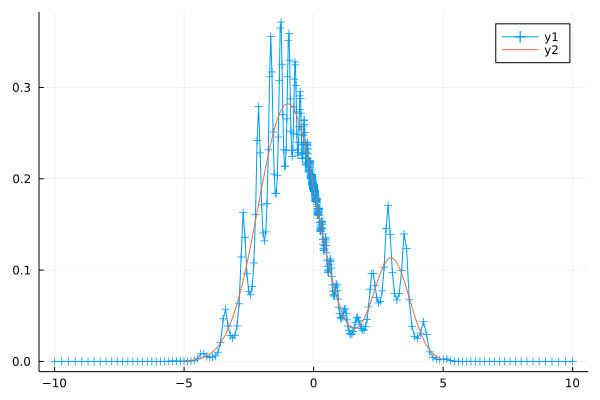

In [89]:
plot(real.(raw_reals.freq), imag.(raw_reals.val)/pi,marker=:+)
#plot(real.(raw_reals.freq), imag.(raw_reals.val)/pi)
plot!(omegas, rho.(omegas))

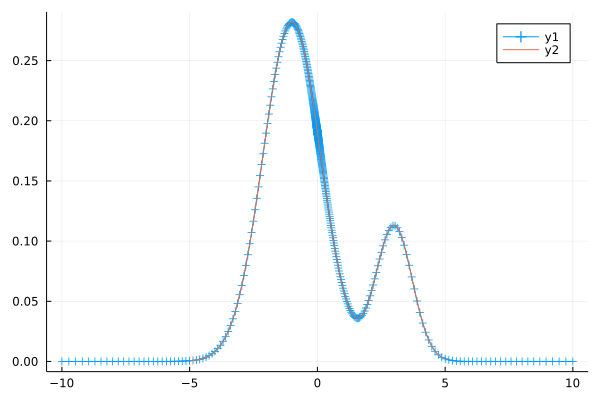

In [90]:
plot()
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val))/pi,marker=:+)
plot!(omegas, rho.(omegas))
#savefig("picture.png")